# Lab-03 Q3 Knowledge Distillation

Please run the code with "VScode-devcontainer".

It is easier to use Git in local.

In [17]:
# install requirements
#
# !pip install pytorchcv torchinfo
# !wget -P data/cifar10_1 https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v6_labels.npy
# !wget -P data/cifar10_1 https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v6_data.npy

In [2]:
# import required libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from pathlib import Path
import torch.nn as nn
import numpy as np
from pytorchcv.model_provider import get_model
from torchinfo import summary
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from utils import Cifar10_1

In [3]:
# define some hyper parameters
DATA_PATH = './data'

# change these hyper parameter if needed
BATCH_SIZE = 32
EPOCH = 10

NUM_CLASSES = 10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# check device (CPU, GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# TODO
# augment data here
# https://pytorch.org/vision/master/transforms.html
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [5]:
# load dataset : CIFAR-10

trainset   = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_1  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testset_2  = Cifar10_1(root='./data/cifar10_1/', transform=transform)

print(trainset.data.shape)
print(testset_1.data.shape)
print(testset_2.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(2000, 32, 32, 3)


In [6]:
# Teacher Model
# Reference: https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py

class AlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
# Get model
model_name = "AlexNet"
model = AlexNet(NUM_CLASSES).to(device)

# Choose loss function
LOSS_FUNCTION = "CrossEntropy"

In [8]:
# Load model parameter
is_load_model_param = True
load_model_param_UUID = 1

# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html
if is_load_model_param:
    model.load_state_dict(torch.load(f"./model/model_{load_model_param_UUID}.pth"))
    model.eval()
    print(f"Loaded model parameters: model_{load_model_param_UUID}.pth")

Loaded model parameters: model_1.pth


In [9]:
summary(model, input_size=(1, 3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

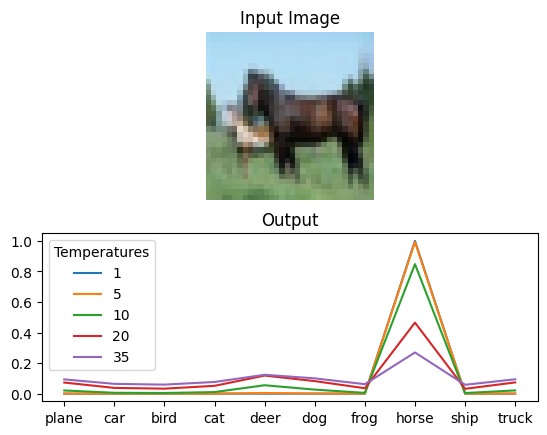

In [10]:
# Test single data
item_idx = 12
figure = plt.figure()

# Get image
item_image = trainset.data[item_idx]
subplot = figure.add_subplot(2, 1, 1)
subplot.axis("off")
subplot.title.set_text("Input Image")  # type: ignore
subplot.imshow(item_image)

# Image Preprocessing
item_image = Image.fromarray(item_image)
item_image = transform(item_image)
item_image = torch.unsqueeze(item_image, dim=0)  # type: ignore

# Get model output
model.eval()
item_image = item_image.to(device)
output = model(item_image)

# Apply temperature & Show Output
temperatures = [1, 5, 10, 20, 35]
subplot = figure.add_subplot(2, 1, 2)
for temperature in temperatures:
    softmax_temperature = torch.softmax(output / temperature, dim=1)
    subplot.plot(classes, softmax_temperature[0].cpu().detach().numpy())
subplot.title.set_text("Output")  # type: ignore
subplot.legend(temperatures, title="Temperatures")

In [17]:
# version control
UUID = 1

hyperparameter_log = {
    "UUID": UUID,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCH": EPOCH,
    "MODEL_NAME": model_name,
    "LOSS_FUNCTION": LOSS_FUNCTION,
    "DEVICE": device.type
}

print(hyperparameter_log)

{'UUID': 1, 'BATCH_SIZE': 32, 'EPOCH': 10, 'MODEL_NAME': 'AlexNet', 'LOSS_FUNCTION': 'CrossEntropy', 'DEVICE': 'cuda'}


In [18]:
# dataloader
trainloader  = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader_1 = DataLoader(testset_1, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader_2 = DataLoader(testset_2, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [42]:
# define loss function
# https://blog.csdn.net/weixin_36670529/article/details/105670337
if LOSS_FUNCTION == "CrossEntropy":
    criterion = nn.CrossEntropyLoss()
elif LOSS_FUNCTION == "MSE":
    criterion = nn.MSELoss()

# or define your own loss function here
# https://discuss.pytorch.org/t/custom-loss-functions/29387
# https://rowantseng.medium.com/pytorch-%E8%87%AA%E5%AE%9A%E7%BE%A9%E6%90%8D%E5%A4%B1%E5%87%BD%E6%95%B8-custom-loss-c12e8741968b
# https://androidkt.com/how-to-add-l1-l2-regularization-in-pytorch-loss-function/
# 😂

# Do not modify this
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
# train
def train(e):
    model.train()
    num_data = 0
    correct = 0
    loss_all = 0

    for i, (x, y) in enumerate(tqdm(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        x, y = x.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(x)

        # compute loss here
        loss = criterion(outputs, y)

        # L2 Regularization
        # Reference: https://androidkt.com/how-to-add-l1-l2-regularization-in-pytorch-loss-function/
        l2_lambda = 0.00005
        l2_norm = sum(param.pow(2.0).sum() for param in model.parameters())
        loss += l2_lambda * l2_norm

        # back prop
        loss.backward()
        optimizer.step()

        # log
        num_data += y.size(0)
        loss_all += loss.item()
        pred = outputs.data.max(1)[1]
        correct += pred.eq(y.view(-1)).sum().item()

    print(f"epoch: [{e}], loss: {loss_all/len(trainloader):.4f}, acc: {correct/num_data:.4f}")


# start training
for e in range(EPOCH):
    train(e)

In [30]:
# evaluate
def test(model, test_loader, loss_fun, device):
    model.eval()
    test_loss = 0
    correct = 0
    targets = []

    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device).long()

        targets.append(target.detach().cpu().numpy())

        output = model(data)

        test_loss += loss_fun(output, target).item()
        pred = output.data.max(1)[1]

        correct += pred.eq(target.view(-1)).sum().item()

    return test_loss/len(test_loader), correct /len(test_loader.dataset)


loss, acc = test(model, testloader_1, criterion, device)
print(f"on testset 1: loss: {loss:.4f}, acc: {acc:.4f}")

loss, acc = test(model, testloader_2, criterion, device)
print(f"on testset 2: loss: {loss:.4f}, acc: {acc:.4f}")


on testset 1: loss: 0.6890, acc: 0.8681
on testset 2: loss: 1.4122, acc: 0.7620


In [31]:
# Save the model
torch.save(model.state_dict(), f'./model/model_{UUID}.pth')

In [32]:
# record the results to a log file (e.g google sheet, )